# Introduction to Dask (and Distributed Computing)

## Limitations of Pandas

This is taken from the [Fugue docs](https://fugue-tutorials.readthedocs.io/tutorials/beginner/introduction.html)

pandas is great for small datasets, but unfortunately does not scale well large datasets. The primary reason is that pandas is single core, and does not take advantage of all available compute resources. A lot of operations also generate [intermediate copies of data](https://pandas.pydata.org/pandas-docs/stable/user_guide/scale.html#scaling-to-large-datasets), utilizing more memory than necessary. To effectively handle data with pandas, users preferably need to have [5x to 10x times as much RAM](https://wesmckinney.com/blog/apache-arrow-pandas-internals/) as the size of the dataset.

Spark and Dask allow us to split compute jobs across multiple machines. They also can handle datasets that don’t fit into memory by spilling data over to disk in some cases. But ultimately, moving to Spark or Dask still requires significant code changes to port existing pandas code. Added to changing code, there is also a lot of knowledge required to use these frameworks effectively.

Pandas enforces vertical scaling by default. When the data exceeds the capcity of the current machine, you need to increase the underlying machine.

<img src="https://www.cloudzero.com/hubfs/blog/horizontal-vs-vertical-scaling.webp" width=600/>

## Memory Bound versus Compute Bound Problems

<img src="https://ml.dask.org/_images/dimensions_of_scale.svg" width=600/>

The [dask-ml](https://ml.dask.org/) has a good introduction to the cases that need distributed compute. They either tend to be compute-bound problems or memory-bound problems. For memory-bound problems, the data literally does not fit on a single machine so we need to divide across multiple machinses and keep track where each partition of data lives.

On the other hand, compute-bound problems are about tasks that take long to execute to we can speed up execution by running them in parallel or distributedly over a cluster. The point is to utilize untapped resoucres that are not consumed when executing sequentially.

## Landscape of Distributed Computing Frameworks

### [Dask](https://dask.org/)

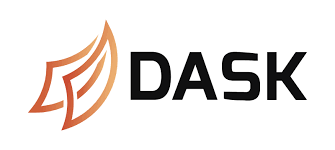

### [Spark](https://spark.apache.org/docs/latest/api/python/)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Apache_Spark_logo.svg/1280px-Apache_Spark_logo.svg.png" width=300/>

### [Ray](https://www.ray.io/)

<img src="https://softwareengineeringdaily.com/wp-content/uploads/2020/02/ray-logo.png" width=300/>

## Parallel Computing versus Distributed Computing

[This O'Reilly page](https://learning.oreilly.com/library/view/distributed-computing-in/9781787126992/7478b64c-8de4-4db3-b473-66e1d1fcba77.xhtml) describes the different of parallel and distributed computing. Parallel computing normally is confided to one machine where the processes can share the same memory, while distributed computing happens over multiple machines. In the distributed scenario, a task and the dependencies are sent to other machines through a network connection.

![img](https://camo.githubusercontent.com/d35e159e77d69d60395afb6023374f5f4decd6a6f7a5aa08d9d17415d75e63db/68747470733a2f2f7777772e6f7265696c6c792e636f6d2f6c6962726172792f766965772f64697374726962757465642d636f6d707574696e672d696e2f393738313738373132363939322f6173736574732f65313135333733392d663535312d346631662d613434612d3865666663643139333039392e706e67)

With that, we can introduce Dask, a distributed computing framework that allows us to scale workflows. Something convenient about Dask is that the local mode is similar to a multiprocessing pool while the distributed mode executes code across a cluster.

## Introduction to Dask

<img src="https://camo.githubusercontent.com/3c64951581aa07190e26664835ef4c5b1e0d108e6f3b1d945a374719e2fd68e9/68747470733a2f2f757365722d696d616765732e67697468756275736572636f6e74656e742e636f6d2f3330363338302f3132393033313337352d38333534376561322d623366642d343632332d616439612d6535376464633233613965362e6a7067" width=500/>

We can see example Dask DataFrame code below, notice the wildcard shows we can load multiple files in parallel. The API was also designed to mirror the Pandas API.

```python
import dask.dataframe as dd
df = dd.read_csv('2014-*.csv')
df.head()
```

Under the hood, Dask DataFrame then takes care of submitting this for execution to the Dask cluster.

In the diagram below, note how:
- package versions and serialization
- reading in files can be optimized
- data actually lives on a physical machine

<img src="https://camo.githubusercontent.com/3b83d2f3637a19be38f50b7776035cd1b24d730f821f3d3fcdccfc5fae3c5310/68747470733a2f2f757365722d696d616765732e67697468756275736572636f6e74656e742e636f6d2f3330363338302f3132393033313431362d66653131376236322d383366362d343763652d393232372d6261386135306462336266382e6a7067" width=600/>

The Client can give on your local computer, and can submit tasks to the Dask cluster. The Schedeuler is the entrypoint that receives this task and decides which worker to send it to. When using the Dask DataFrame API, Dask handles the lower level managing of sending partitions to workers or rearranging the data across the cluster. This is called a shuffle in distributed compute terms.



# Map_Partition example

In [33]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

X = pd.DataFrame({"x_1": [1, 1, 2, 2], "x_2":[1, 2, 2, 3]})
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)

In [35]:
def predict(df: pd.DataFrame, model: LinearRegression) -> pd.DataFrame:
    return df.assign(predicted=model.predict(df))

input_df = pd.DataFrame({"x_1": [3, 4, 6, 6], "x_2":[3, 3, 6, 6]})

predict(input_df, reg)

,x_1,x_2,predicted
0,3,3,12.0
1,4,3,13.0
2,6,6,21.0
3,6,6,21.0


In [37]:
import dask.dataframe as dd

dask_df = dd.from_pandas(input_df, npartitions=2)
ddf = dask_df.map_partitions(predict, reg)
ddf.compute().head()

,x_1,x_2,predicted
0,3,3,12.0
1,4,3,13.0
2,6,6,21.0
3,6,6,21.0


## Basic Syntax, Spark versus Dask

In [40]:
import pandas as pd
from typing import Dict

df = pd.DataFrame({"id":[0,1,2], "value": (["A", "B", "C"])})
map_dict = {"A": "Apple", "B": "Banana", "C": "Carrot"}

def map_letter_to_food(df: pd.DataFrame, mapping: Dict[str, str]) -> pd.DataFrame:
    df["value"] = df["value"].map(mapping)
    return df

map_letter_to_food(df, map_dict)

,id,value
0,0,Apple
1,1,Banana
2,2,Carrot


**Dask**

In [41]:
df = pd.DataFrame({"id":[0,1,2], "value": (["A", "B", "C"])})
ddf = dd.from_pandas(df, npartitions=2)
ddf["value"] = ddf["value"].map(map_dict)
ddf.compute()

ValueError: Exactly one of npartitions and chunksize must be specified.

**Spark**

In [32]:
from itertools import chain
from pyspark.sql.functions import create_map, lit
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

mapping = create_map([lit(x) for x in chain(*map_dict.items())])
sdf = spark.createDataFrame(df)
sdf = sdf.withColumn("food", mapping[sdf['value']])
sdf.show()

+---+-----+------+
| id|value|  food|
+---+-----+------+
|  0|    A| Apple|
|  1|    B|Banana|
|  2|    C|Carrot|
+---+-----+------+



## Dask collections

But while we have discussed this in the context of DataFrames, the DataFrame concept is just one of the available collections. In fact, it is a collection more associated with memory-bound problems while workflow orchestration usage of Dask tends to be compute-based problems.

The diagram below shows the other available collections.

![img](https://camo.githubusercontent.com/62741530885939ba21ad5a3f72bf130fbf880423fa331136004e95f78d73a948/68747470733a2f2f757365722d696d616765732e67697468756275736572636f6e74656e742e636f6d2f3330363338302f3132393033313338382d36666364306364312d393634332d346633642d623462312d6336653334336262636630382e6a7067)

The Dask Bag is like a distributed dictionary or JSON. The Dask Array builds on top of xarray. But the collection that is most relevant to workflow orchestration is Futures.

## Dask Futures

Dask Delayed and Dask Futures allow for the submission of arbitrary code to the Dask scheduler. The Dask scheduler then directs the execution to a worker. The difference is that Dask Delayed is evaluated lazily, allowing the computation graph to compile before execution. Knowing the execution graph ahead of time allows Dask to optimize it by analyzing the data dependencies and ensuring that workers have all the dependencies they need to execute tasks. Dask Futures, on the other hand are executed immediately.

Below is an example of using the Future interface, which is what Prefect does to submit tasks to a Dask cluster. Here, we perform the execution on a local cluster.

In [42]:
from dask.distributed import Client

client = Client(processes=False)

def inc(x):
    return x + 1

a = client.submit(inc, )
print(a)
print(a.result())

<Future: pending, key: inc-88110521fcd41acdd80fda11113e42d2>
11


## Cloudpickle Limitations

## Prefect Using Dask

Take the following DAG structure. We have two upstream tasks that then fork out into three independent tasks.

![img](https://camo.githubusercontent.com/e93383a93eedd9c05d9875ecb39f350acb8b3c796a6ddb9b89e22bedd6b1ccaf/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f313430302f312a5934573670486b505162637a6f6d6e685237505a64512e6a706567)

If each of the three tasks takes 10 minutes to run, then running them sequentially will take 30 minutes. But if we have enough compute resources, we can just run them in parallel instead and reduce the execution time by 2/3rds. When tasks are independent, we can run them concurrently.

Note that the independent tasks do not have to be homogenous tasks. They can be entirely different functions as long as they are independent.

This section will cover how to execute tasks parallelly or distributedly.

Before talking about how to parallelize, we just need to clarify two terms that will be used a lot.

## When to use Dask versus Prefect

People already familiar with Dask wonder what Prefect adds because Dask already seemingly has a lot of the features Prefect brings. For example, Dask already has

* Retries of code
* Scheduling of tasks
* A Directed Acyclic Graph (DAG)
* Handling of dependencies

So when do we use Dask versus Prefect? Or how are they used together?

**The Prefect DAG**

The Prefect DAG is more robust in handling state. For example, it is superior in the following cases:

* restarting a failed Flow from the checkpoint
* caching across multiple flow runs
* linking results to Flow runs (and parameters) through the GraphQL API
* observability into why a Flow failed (additional logging)

So what is the relationship of the Dask DAG and the Prefect DAG? Prefect is a more macro-level workflow orchestrator while Dask focuses on compute (micro-level). Prefect cares more across Flow runs while you would need to add extra code for Dask to Handle it.

In [ ]:
with Flow() as flow:
    a = task_a.map()
    b = task_b.map(a)
    task_c.map(b)

## Mapping in Prefect 1.0 (Depth First Execution)

There is actually an edge case when the Dask DAG is used. This is when we have multiple stages of mapping. For example, check the two-stage mapping operation below. By submitting multiple stages to Dask together, we can execute them in a depth-first fashion. This eliminates the need to collect intermediate results before running the next task.

![img](https://camo.githubusercontent.com/ea770293514c19e912414779412502c99178aa24bbb2f585c9585ca082c24b02/68747470733a2f2f6d69726f2e6d656469756d2e636f6d2f6d61782f3630322f312a4b4f692d6b5361516444496454534768614f47656e412e706e67)

When these are submitted together, the Dask DAG is used (and sometimes overlaps with the Prefect DAG). For example, if a Dask worker dies, the different stages can be executed again (sometimes duplicated). This is because Dask revives the worker and from it's perspective, does not realize that earlier tasks have been completed and the checkpoint can be used.

## Failure mode in distributed computing

## Dask versus other distributed computing frameworks

When Prefect started out, it specifically was exploring performing Airflow-like workflow orchestration semantics on top of the Dask milli-second latency scheduler. This is because the Airflow scheduler took 10 seconds to submit a task. But why Dask specifically compared to Spark?

Spark and Dask are the most widely adopted distributed compute interfaces for Python. The difference though is that Spark has leaned more heavily towards the DataFrame abstraction and has optimized for that. It's very easy in Dask to submit an abitrary function with

client.submit(fn)
whereas in Spark it's not even straightforward how to perform this operation. In [this](https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html) blog by Databricks, they recommend using the DataFrame API.

Ray, though has been gaining steam as a distributed computing framework so we added a task runner for it in Orion. The docs can be [found here](https://orion-docs.prefect.io/tutorials/dask-ray-task-runners/). The benefits of Ray over Dask were discussed [here](https://github.com/PrefectHQ/prefect/issues/3963). Namely (mentioned by Github user Hoeze):

* Ray would make it easy to define resources that a certain task needs (e.g. GPU, memory):
* Also, it's shared-memory object store is just superior to Dask's deserialization for large objects when working with Dask tasks (e.g. check [dask-on-ray](https://github.com/ray-project/ray/issues/13620) Zero-copy deserialization of dask.delayed() objects.

## CSV versus Parquet

## Setting-up a Dask cluster
One reason why Dask is widely adopted is because of the ease of spinning up your own ephemeral cluster for the duration of an application (or flow run). This documentation page contains the various ways that a Dask cluster can be deployed. The choice of cluster largely depeneds on your infrastructure. The most commons ones are:

* Dask on Kubernetes
* Dask on AWS/ECS or Fargate
* Managed services like [Coiled](https://coiled.io/) or [Saturn Cloud](https://saturncloud.io/)

The important thing to note in distributed systems is that the package versions on the workers need to be the same as the scheduler and client. Otherwise, it's very easy to run into inconsistent execution, or programs will raise an error. Most Dask cluster initialization method will take in a Docker base image that can be used to spin-up the workers. This guarantees execution.

For example, this is what spinning up a Dask cluster looks like with a KubeCluster

```python
from dask_kubernetes import KubeCluster, make_pod_spec

pod_spec = make_pod_spec(image='prefecthq/prefect:latest')
cluster = KubeCluster(pod_spec)
cluster.scale(10)
```
This is why it's important to know how to build your own image to include the dependencies

After this, you can connect the Client with:

```python
client = Client(cluster)
```
but Prefect does it for you under the hood in order to submit your tasks.

## Using DaskExecutor in Prefect 1

```python
executor = DaskExecutor(
    cluster_class="dask_cloudprovider.FargateCluster",
    cluster_kwargs={
        "image": "prefecthq/prefect:latest",
        "n_workers": 5,
        ...
    },
)
```

## Using the Dask TaskRunner for Orion

Utilizing the DaskTaskRunner in Prefect Orion is as simple as adding it to the @flow decorator. If not specified, the default Task Runner used is the ConcurrentTaskRunner, which actually runs tasks asynchronously already. It should be comparable to Dask on local, and now Dask can scale beyond one machine.

The ConcurrentTaskRunner was introduced to remove the Dask dependency for local parallelism.

```python
from prefect import flow, task
from prefect.task_runners import DaskTaskRunner

@task
def say_hello(name):
    print(f"hello {name}")

@task
def say_goodbye(name):
    print(f"goodbye {name}")

@flow(task_runner=DaskTaskRunner())
def greetings(names):
    for name in names:
        say_hello(name)
        say_goodbye(name)

if __name__ == "__main__":
    greetings(["arthur", "trillian", "ford", "marvin"])
```

We can then pass a callable or address to the DaskTaskRunner to create an ephemeral cluster or connec to an already existing cluster.

```python
DaskTaskRunner(
    cluster_class="dask_cloudprovider.FargateCluster",
    cluster_kwargs={
         "image": "prefecthq/prefect:latest",
         "n_workers": 5,
    },
)
```

Note we can also do the same for Ray. In the next section, we'll see how to create our own image that we can use to guarantee consistency across Flow Runs and when creating a cluster.

## [Reference on Partitions](https://blog.scottlogic.com/2018/03/22/apache-spark-performance.html) by Scott Logic

This reference has a lot of good images and explanations

### Ideal Partitioning Strategy
![Partitioning](https://blog.scottlogic.com/mdebeneducci/assets/Ideal-Partitioning.png)
### Skewed Partitions
![Skewed Partitions](https://blog.scottlogic.com/mdebeneducci/assets/Skewed-Partitions.png)
### Inefficient Scheduling
![Inefficient Scheduling](https://blog.scottlogic.com/mdebeneducci/assets/Inefficient-Scheduling.png)
### Data Shuffling
![Shuffle](https://blog.scottlogic.com/mdebeneducci/assets/Shuffle-Diagram.png)

## Pitfalls of Distributed Computing

### Inefficient Partitioning

In [2]:
import pandas as pd
import dask.dataframe as dd
from time import sleep

def delay(df:pd.DataFrame) -> pd.DataFrame:
    sleep(df.shape[0]*3)
    return df.assign(b=df.shape[0])

pdf = pd.DataFrame([[0],[1],[2],[3],[4],[5],[6],[7]], columns=["a"])
pdf

,a
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7


In [3]:
%%time
ddf = dd.from_pandas(pdf, npartitions=4)
ddf.map_partitions(delay, meta={"a":"int32","b":"int32"}).compute()

CPU times: user 592 ms, sys: 71.8 ms, total: 664 ms
Wall time: 6.05 s


,a,b
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2
5,5,2
6,6,2
7,7,2


In [4]:
%%time
pdf = pd.DataFrame([[0],[1],[2],[3]], columns=["a"])
ddf = dd.from_pandas(pdf, npartitions=4)
ddf.map_partitions(delay, meta={"a":"int32","b":"int32"}).compute()

CPU times: user 514 ms, sys: 55.5 ms, total: 569 ms
Wall time: 6.04 s


,a,b
0,0,1
1,1,1
2,2,2
3,3,2


## Lineage and Persisting

In [5]:
import numpy as np

In [6]:
%%time
def gen_data(df: pd.DataFrame) -> pd.DataFrame:
    sleep(df.shape[0]*3)
    return df.assign(b=np.random.random((df.shape[0], 1)))

pdf = pd.DataFrame([[0],[1],[2],[3],[4],[5],[6],[7]], columns=["a"])
result = gen_data(pdf)
print(result)
print(result.head(3))

   a         b
0  0  0.651542
1  1  0.810021
2  2  0.076631
3  3  0.138025
4  4  0.202097
5  5  0.956513
6  6  0.738100
7  7  0.793247
   a         b
0  0  0.651542
1  1  0.810021
2  2  0.076631
CPU times: user 1.32 s, sys: 183 ms, total: 1.5 s
Wall time: 24 s


In [7]:
%%time
ddf = dd.from_pandas(pdf, npartitions=4)
result = ddf.map_partitions(gen_data, meta={"a": "int32", "b":"i8"})
print(result.compute())
print(result.head(3))

   a         b
0  0  0.608975
1  1  0.082308
2  2  0.577186
3  3  0.724430
4  4  0.822322
5  5  0.159231
6  6  0.980479
7  7  0.696390
   a         b
0  0  0.486628
1  1  0.161387
CPU times: user 1.05 s, sys: 120 ms, total: 1.17 s
Wall time: 12.1 s


/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/dask/dataframe/core.py:7352: UserWarning: Insufficient elements for `head`. 3 elements requested, only 2 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


In [8]:
%%time
ddf = dd.from_pandas(pdf, npartitions=4)
result = ddf.map_partitions(gen_data, meta={"a": "int32", "b":"i8"}).persist()
print(result.compute())
print(result.head(3))

   a         b
0  0  0.924826
1  1  0.434186
2  2  0.533162
3  3  0.919182
4  4  0.520236
5  5  0.027585
6  6  0.524088
7  7  0.169923
   a         b
0  0  0.924826
1  1  0.434186
CPU times: user 637 ms, sys: 64.3 ms, total: 701 ms
Wall time: 6.07 s


/opt/miniconda3/envs/fugue-tutorials/lib/python3.8/site-packages/dask/dataframe/core.py:7352: UserWarning: Insufficient elements for `head`. 3 elements requested, only 2 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


## Schema Inference

In [9]:
def add_col(df):
    print(df["a"].iloc[0])
    if df["a"].iloc[0] == 7:
        return df.assign(b=None)
    else:
        return df.assign(b=1)
    
pdf = pd.DataFrame([[x] for x in range(8)], columns=["a"])
pdf

,a
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7


In [10]:
pdf.groupby("a").apply(add_col)

0
1
2
3
4
5
6
7


,a,b
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
5,5,1
6,6,1
7,7,None


In [11]:
pdf.groupby("a").apply(add_col).dtypes

0
1
2
3
4
5
6
7


a     int64
b    object
dtype: object

In [12]:
ddf = dd.from_pandas(pdf, npartitions=2)
ddf.groupby("a").apply(add_col).dtypes

1


/var/folders/x5/f4r6ylss0k7dwh8c_0dmzd_40000gn/T/ipykernel_5975/2870419602.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  ddf.groupby("a").apply(add_col).dtypes


a    int64
b    int64
dtype: object

In [13]:
def add_col_2(df):
    if df["a"].iloc[0] == 1:
        sleep(5)
    return df.assign(b=1)

In [14]:
%%time
ddf.groupby("a").apply(add_col_2).dtypes

CPU times: user 324 ms, sys: 44.2 ms, total: 369 ms
Wall time: 5.03 s


<timed eval>:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result


a    int64
b    int64
dtype: object

In [15]:
%%time
ddf.groupby("a").apply(add_col_2).compute()

<timed eval>:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result


CPU times: user 759 ms, sys: 91.9 ms, total: 851 ms
Wall time: 10.1 s


,a,b
1,1,1
0,0,1
2,2,1
3,3,1
4,4,1
5,5,1
6,6,1
7,7,1
